# Zadanie 2 

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

## Klasyczne testowanie 

In [69]:

np.random.seed(seed=123)

# Zakres stopni swobody, jakie zaprezentuję na wykresie
stopnie_swobody = range(1, 30, 1)  # Zakres od 1-50 co 1
# Ustalam poziom istotności
poziom_istotnosci = 0.05
# Liczba danych dla jakich wykonam symulacje
liczby_danych = [10, 20, 50,100]
# Liczba symulacji na jakich będę bazować
liczba_symulacji = 500


In [62]:
def symulacja(l_danych,stopien_s,test):

    # W tej zmiennej będę sumował liczbę razy, gdy dla danego zestawu danych odrzuciłem hipotezę zerową
    suma_odrzucenia_H0 = 0

    for k in range(liczba_symulacji):
        # Tworzę próbkę danych z rozkładu chi kwadrat o stopien_s stopni swobody
        probka = stats.chi2.rvs(stopien_s,size=l_danych)
        # Tutaj jest moment decyzyjny, gdzie decyduje który test teraz symulowany
        
        # Test Chi-kwadrat
        if test == "chi":
            # Dziele dane na przedziały
            exp = np.ones(stopien_s)/stopien_s
            freq,temp = np.histogram(probka, bins='auto')
            if stats.chisquare(probka).pvalue < poziom_istotnosci:
                suma_odrzucenia_H0 += 1

        # Test Kołgomorova
        elif test == "kolmog":
            if stats.kstest(probka,stats.chi2(stopien_s).cdf).pvalue < poziom_istotnosci:
                suma_odrzucenia_H0 += 1

    return suma_odrzucenia_H0/liczba_symulacji

In [63]:

def symulacja_testu(test):

    # Tablica, która zbierze mi moce testów
    moce_testow = []

    # Zaczynamy symulacje
    # Dla każdej liczby danych
    for l_danych in liczby_danych:
        # Tworzę nową tablicę która będzie przechowywała
        # moce testu dla n-tej liczby danych
        moce_n_testu = []

        # Dla każdego stopnia swobody
        for stopien_s in stopnie_swobody:
            # Symulacja, dla danego zestawu danych
            odsetek_odrzucenia_H0 = symulacja(l_danych,stopien_s,test)

            # Dodajemy odsetek odrzucenia dla danego stopnia swobody i danej liczby danych i idziemy dalej, zwiększając 
            # stopnie swobody
            moce_n_testu.append(odsetek_odrzucenia_H0)

        # Teraz dodajemy moce n-tego testu do głownej tablicy przechowującej moce testu
        moce_testow.append(moce_n_testu)

    # Symulacja zakonczona i zwracam moce testów

    return moce_testow



In [64]:
moc_kol = symulacja_testu("kolmog")
# Tworzę podstawkę do wykresu 
wykres_shapiro = plt.figure()


# Dodaje dane do wykresu 
for moc in moc_kol:
    plt.plot(stopnie_swobody,moc)
    # Dodaję punkt dla pierwszego elementu


# Czcionka dla tytulu
font_title = {'family' :'serif','size':17}

# Dodaje opisy do wykresu 
plt.xlabel("Stopnie swobody")
plt.ylabel("Moc Testu")
plt.title("Test Kolmogoorowa",fontdict=font_title)
plt.ylim(0)
plt.show()

KeyboardInterrupt: 

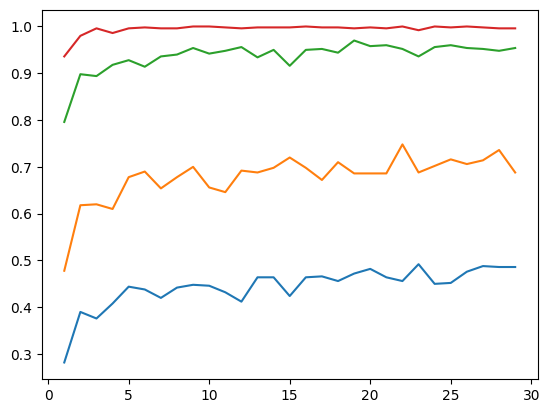

In [ ]:
moc_chi = symulacja_testu("chi")

for moc in moc_chi:
    plt.plot(stopnie_swobody,moc)
    # Dodaję punkt dla pierwszego elementu
plt.show()


In [67]:
def pit():

    # Tablica, która zbierze mi moce testów
    moce_testow = []

    # Zaczynamy symulacje
    # Dla każdej liczby danych
    for l_danych in liczby_danych:
        # Tworzę nową tablicę która będzie przechowywała
        # moce testu dla n-tej liczby danych
        moce_n_testu = []

        # Dla każdego stopnia swobody
        for stopien_s in stopnie_swobody:
            # Symulacja, dla danego zestawu danych
            odsetek_odrzucenia_H0 = 0

            for k in range(liczba_symulacji):
                probka = stats.chi2.rvs(stopien_s,size=l_danych)

                rang = stats.rankdata(probka)
                dystr = rang/len(probka)

                uni_dystr = np.random.uniform(size=len(probka))

                if stats.kstest(dystr,'uniform').pvalue < 0.05:
                    odsetek_odrzucenia_H0 +=1 


            # Dodajemy odsetek odrzucenia dla danego stopnia swobody i danej liczby danych i idziemy dalej, zwiększając 
            # stopnie swobody
            moce_n_testu.append(odsetek_odrzucenia_H0)

        # Teraz dodajemy moce n-tego testu do głownej tablicy przechowującej moce testu
        moce_testow.append(moce_n_testu)

    # Symulacja zakonczona i zwracam moce testów

    return moce_testow


In [70]:
moc_pit = pit()

for moc in moc_chi:
    plt.plot(stopnie_swobody,moc)
    # Dodaję punkt dla pierwszego elementu
plt.show()


IndexError: index 31 is out of bounds for axis 0 with size 31